# Dataloaders

In [1]:
# Importing libraries
import torchio as tio
import glob
import numpy as np
import random
import os
import pickle

from collections import OrderedDict
from pathlib import Path

from tqdm import tqdm
import time

import torchio as tio
from torchio.transforms import (RescaleIntensity,RandomFlip,Compose, HistogramStandardization)

from sklearn.metrics import accuracy_score

from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f) 

In [3]:
def assign_ids_to_groups(category, groups, nr_con_per_dataset, nr_alb_per_dataset=[]):
    
    # Create dictionary for given category (public, UoN, CHIASM) storing IDs of relevant subjects
    dictionary={}
    
    # Run only for datasets (train, train_dev, test_dev, test) where action is needed
    nonzeroind = np.nonzero(nr_con_per_dataset)[0]
    datasets=['train','train_dev','test_dev','test']
    
    for i in nonzeroind:

        # Select only relevant datasets (see comment above)
        dataset=datasets[i]

        dictionary[dataset]={}
    
    for group in groups:
        
        # Create list of indices for given dataset (e.g. HCP, ABIDE)
        tmp_ids = [os.path.basename(path) for path in glob.glob('../../1_Data/1_Input/'+group+'/*')]
        random.shuffle(tmp_ids)
        
        # If the dataset contains data from both control and albinism, the equal split must be ensured
        if nr_alb_per_dataset:
            
            con_ids=[]
            alb_ids=[]
            
            for subid in tmp_ids:
                if subid in ids_albinism:
                    alb_ids.append(subid)
                else:
                    con_ids.append(subid)

            for i in nonzeroind:

                dataset = datasets[i]

                dictionary[dataset][group]={}
                
                candidates = con_ids[:nr_con_per_dataset[i]] + alb_ids[:nr_alb_per_dataset[i]]
                random.shuffle(candidates)
                
                dictionary[dataset][group]= candidates
                
                del con_ids[:nr_con_per_dataset[i]]
                del alb_ids[:nr_alb_per_dataset[i]]
        
        # Otherwise no action is required
        else:
    
            for i in nonzeroind:

                # Only for datasets where we require a >0 participants
                dataset=datasets[i]

                dictionary[dataset][group]={}

                # Select first X participants from the list and delete them
                dictionary[dataset][group]=tmp_ids[:nr_con_per_dataset[i]]
                del tmp_ids[:nr_con_per_dataset[i]]

    save_obj(dictionary, 'ids_'+str(category))
    
    return dictionary

In [4]:
# List IDs of all participants with albinism
ids_albinism=['Nyst01','Nyst02','Nyst03','Nyst04','Nyst05','Nyst06','Nyst07','Nyst08','Nyst09',
              'Nyst10','Nyst11','Nyst12','Nyst13','Nyst16','Nyst20','Nyst21','Nyst24', 'Nyst25',
              'Nyst31','Nyst35','Nyst37','Nyst43','Nyst45','sub-ALB1','sub-ALB2','sub-ALB3','sub-ALB4',
              'sub-ALB5','sub-ALB6','sub-ALB7','sub-ALB8','sub-ALB9'] 

In [5]:
# Create dictionaries asigning subjects to train/train_dev/test_dev/test groups
public=['HCP']
UoN=['UoN']
CHIASM=['CHIASM']

for group in public:
    print(len([os.path.basename(path) for path in glob.glob('../../1_Data/1_Input/'+group+'/*')]))
public_dict = assign_ids_to_groups('public',public,[20,10,0,0])

for group in UoN:
    print(len([os.path.basename(path) for path in glob.glob('../../1_Data/1_Input/'+group+'/*')]))
UoN_dict = assign_ids_to_groups('UoN',UoN,[16,5,0,0],[17,5,0,0])

for group in CHIASM:
    print(len([os.path.basename(path) for path in glob.glob('../../1_Data/1_Input/'+group+'/*')]))
CHIASM_dict = assign_ids_to_groups('CHIASM',CHIASM,[0,0,3,5],[0,0,3,6])

1111
43
17


In [6]:
# Merge obtained dictionary into a single one with study design
design = {}

design['train']={}
design['train_dev']={}
design['test_dev']={}
design['test']={}

In [7]:
list_of_dictionaries = ['public_dict','UoN_dict','CHIASM_dict']

for dictionary_name in list_of_dictionaries:
    
    processed_dictionary = eval(dictionary_name)
    
    for dataset_key in list(processed_dictionary.keys()):
    
        for group_key in list(processed_dictionary[dataset_key].keys()):
    
            for subid in processed_dictionary[dataset_key][group_key]:
            
                path_to_folder='../../1_Data/1_Input/'+group_key+'/'+subid+'/'
        
                files={}
                files['brain']=path_to_folder+'brain_skull-stripped.nii.gz'
                files['probs']=path_to_folder+'sampling_distribution.nii.gz'
                files['chiasm']=path_to_folder+'chiasm.nii.gz'
                files['is_alb']=1 if subid in ids_albinism else 0
                
                design[dataset_key][subid]=files
                
                # The training dataset contains 36 controls (20 from HCP and 16 from UoN) and 17 people with albinism
                # The sample of albinism is upsampled by a factor of 2 to aid the training
                if (dataset_key == 'train' and group_key == "UoN" and subid in ids_albinism):
                    design[dataset_key][subid+'_2']=files
                

In [8]:
# Data preprocessing and augmentation

# Rescale
rescale = RescaleIntensity((0,1))

# Flip
flip = RandomFlip((0,1,2), flip_probability=0.5, p=0.25)

# Composing transforms - flip serves as data augmentation and is used only for training
transform_train = Compose([rescale, flip])
transform_dev = Compose([rescale])

In [9]:
# Dictionary with all chiasm images
subjects_chiasms_list = {'train': [tio.Subject(t1=tio.Image(design['train'][sub]['chiasm'], type=tio.INTENSITY), albinism =design['train'][sub]['is_alb']) for sub in design['train']],
                'train_dev': [tio.Subject(t1=tio.Image(design['train_dev'][sub]['chiasm'], type=tio.INTENSITY), albinism =design['train_dev'][sub]['is_alb']) for sub in design['train_dev']],
                'test_dev':[tio.Subject(t1=tio.Image(design['test_dev'][sub]['chiasm'], type=tio.INTENSITY), albinism =design['test_dev'][sub]['is_alb']) for sub in design['test_dev']],
                'test':[tio.Subject(t1=tio.Image(design['test'][sub]['chiasm'], type=tio.INTENSITY), albinism =design['test'][sub]['is_alb']) for sub in design['test']]}

In [10]:
# Dataset containing only chiasm images
dataset_chiasms = {'train': tio.SubjectsDataset(subjects_chiasms_list['train'], transform = Compose([rescale, flip])),
           'train_dev': tio.SubjectsDataset(subjects_chiasms_list['train_dev'], transform = Compose([rescale])),
           'test_dev': tio.SubjectsDataset(subjects_chiasms_list['test_dev'], transform = Compose([rescale])),
           'test': tio.SubjectsDataset(subjects_chiasms_list['test'], transform = Compose([rescale]))}

In [11]:
# Standard dataloader with images of chiasm

# Dataloader
dataloader_chiasms={'train': DataLoader(dataset=dataset_chiasms['train'], batch_size = 10, shuffle=True, num_workers =8),
            'train_dev': DataLoader(dataset=dataset_chiasms['train_dev'], batch_size = 10, shuffle=True, num_workers =8),
            'test_dev': DataLoader(dataset=dataset_chiasms['test_dev'], batch_size = 10, shuffle=True, num_workers =8),
            'test': DataLoader(dataset=dataset_chiasms['test'], batch_size = 10, shuffle=True, num_workers =8)
           }

train


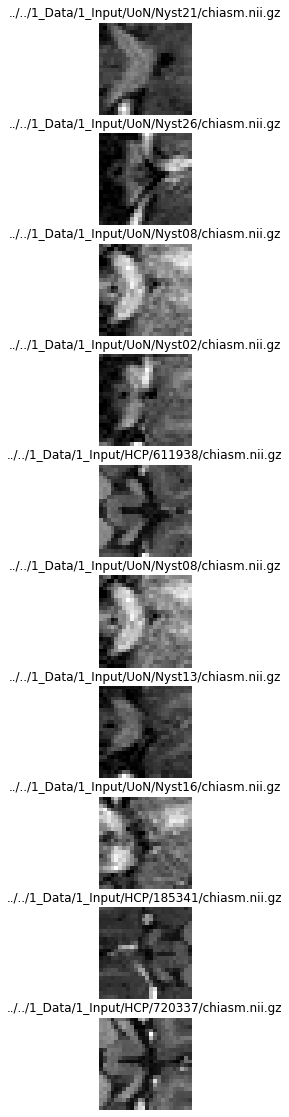

train_dev


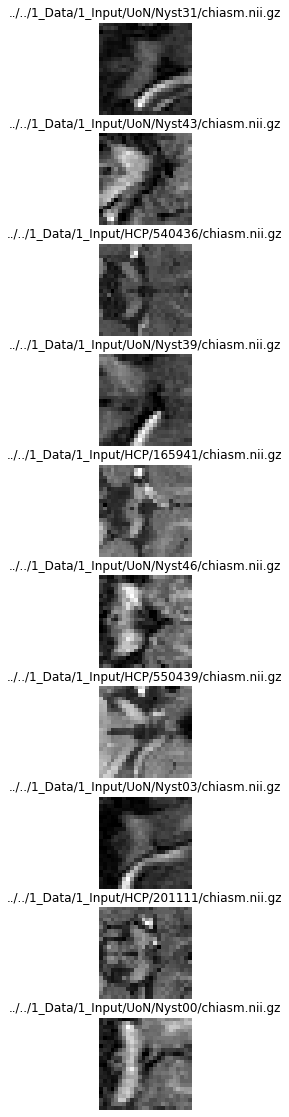

test_dev


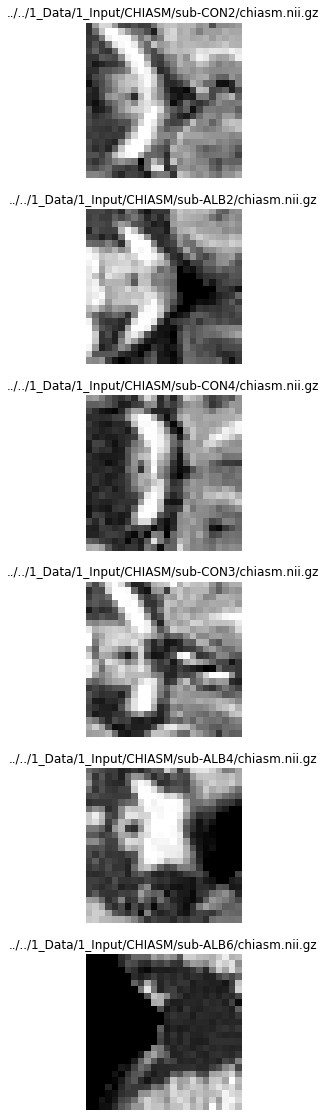

In [12]:
# Visualize results
for group in ['train', 'train_dev', 'test_dev']:
    
    print(group)
    
    batch = next(enumerate(dataloader_chiasms[group]))
    
    data = batch[1]['t1']['data']
    labels = batch[1]['t1']['path']
    
    inputs = data.cpu().numpy()

        
    fig = plt.figure(figsize=(20,20))
    
    for i in range(inputs.shape[0]):
        
        plt.subplot(inputs.shape[0],1,i+1)
        plt.imshow(inputs[i,0,:,:,5],cmap='gray');
        plt.title(labels[i])    
        plt.axis('off')
    
    plt.show()

In [13]:
batch[1]['t1']['path']

['../../1_Data/1_Input/CHIASM/sub-CON2/chiasm.nii.gz',
 '../../1_Data/1_Input/CHIASM/sub-ALB2/chiasm.nii.gz',
 '../../1_Data/1_Input/CHIASM/sub-CON4/chiasm.nii.gz',
 '../../1_Data/1_Input/CHIASM/sub-CON3/chiasm.nii.gz',
 '../../1_Data/1_Input/CHIASM/sub-ALB4/chiasm.nii.gz',
 '../../1_Data/1_Input/CHIASM/sub-ALB6/chiasm.nii.gz']

In [14]:
batch

(0,
 {'t1': {'data': tensor([[[[[5.0346e-01, 3.6805e-01, 3.9686e-01,  ..., 2.1973e-01,
               7.3669e-01, 1.0000e+00],
              [6.3509e-01, 2.9020e-01, 3.5487e-01,  ..., 6.2392e-01,
               1.0000e+00, 9.8572e-01],
              [5.6859e-01, 3.8969e-01, 3.9164e-01,  ..., 8.5687e-01,
               1.0000e+00, 9.5969e-01],
              ...,
              [9.6606e-01, 7.8463e-01, 7.3424e-01,  ..., 5.6380e-01,
               6.9140e-01, 7.7435e-01],
              [1.0000e+00, 7.3354e-01, 6.8395e-01,  ..., 5.8419e-01,
               6.7443e-01, 7.0254e-01],
              [9.3356e-01, 6.7934e-01, 6.9280e-01,  ..., 6.2398e-01,
               6.0826e-01, 7.1688e-01]],
   
             [[8.2208e-01, 4.0150e-01, 2.8587e-01,  ..., 2.2217e-01,
               3.7590e-01, 7.7380e-01],
              [9.2132e-01, 5.1195e-01, 2.4171e-01,  ..., 4.4694e-01,
               8.6624e-01, 1.0000e+00],
              [7.2347e-01, 3.5798e-01, 2.7665e-01,  ..., 7.8375e-01,
               1.

# Network

In [15]:
# U-Net architecture

class UNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1, init_features=64, scaling=2):
        super(UNet, self).__init__()
                
        # Encoding layers
        self.encoder1 = self.unet_block(in_channels, init_features, "enc1")
        self.pool1 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)
        self.encoder2 = self.unet_block(init_features, int(init_features/scaling), name='enc2')
        self.pool2 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)

        # Bottleneck layer
        self.bottleneck = self.unet_block(int(init_features/scaling), int(init_features/(scaling**2)), name='bottleneck')
        
        # Decoding layers (where merge with prevois encoding layers occurs)        
        self.upconv2 = nn.ConvTranspose3d(int(init_features/(scaling**2)), int(init_features/scaling), kernel_size=2, stride=2)
        self.decoder2 = self.unet_block(int(init_features/scaling), int(init_features/scaling), name='dec2')
                
        self.upconv1 = nn.ConvTranspose3d(int(init_features/scaling), init_features, kernel_size=2, stride=2)
        self.decoder1 = self.unet_block(init_features, init_features, name='dec1')
        
        # Final convolution - output equals number of output channels
        self.conv = nn.Conv3d(init_features, out_channels, kernel_size=1) 
        
    def forward(self,x):
        
        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))

        # Upconvolving, concatenating data from respective encoding phase and executing UNet block
        dec2 = self.upconv2(bottleneck)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return torch.sigmoid(out_conv)
    
    def unet_block(self, in_channels, features, name):
        
        return nn.Sequential(OrderedDict([(name+'conv1',nn.Conv3d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm1', nn.BatchNorm3d(num_features=features)),
                             (name+'relu1', nn.ReLU(inplace=True)),
                             (name+'conv2', nn.Conv3d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm2', nn.BatchNorm3d(num_features=features)),
                             (name+'relu2', nn.ReLU(inplace=True))])
                            )

    def output_latent_representations(self,x):
        
        print(x.shape)

        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))
        
        print(bottleneck.shape)
        
        return bottleneck

In [199]:
class Classify_chiasm(nn.Module):
    
    def __init__(self, weights_file='50ep_0005lr.pt'):
        super(Classify_chiasm, self).__init__()
        
        # Initialize the network_extracting_features and load its weights
        network_extracting_features = UNet(1,1,64,2)
        network_extracting_features.load_state_dict(torch.load(weights_file))
        
        child = network_extracting_features.children()
        
        # Copying the desired components (analysis stream) from network_extracting_features
        self.feature_extraction = nn.Sequential(*list(child)[:5])
        
        # Classification layers
        self.classifier = nn.Linear(16*6*6*2,1)
        
        # Placeholder for gradients
        self.gradients = None
    
    # Freeze all the layers apart from the classifying one
    def freeze_feature_extraction(self):
        
        counter = 0
        for layer in classifying_network.children():
            counter += 1
            if counter < 2:
                #print(layer)
                for param in layer.parameters():
                    param.requires_grad = False
            
    # Hook for the activations' gradients
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self,x):
        
        # To ensure that gradients will be tracked
        #x.requires_grad = True
        
        # Feature extraction
        x = self.feature_extraction(x)
        
        # Register the hook
        if self.train and x.requires_grad:
            h = x.register_hook(self.activations_hook)

        # Flatten the image
        #x = torch.flatten(x, start_dim=1)
        x = x.view((x.shape[0], -1))        

        # Classifying FC layer and activation function
        x = self.classifier(x)
        
        return torch.sigmoid(x)

    # Output latent representations (or activations) of the last CNN layer
    def output_latent_representations(self,x):        
        return self.feature_extraction(x)     
    
    # Output gradient
    def output_activation_gradient(self):
        return self.gradients
    
    def gradcam(self, x):
        
        # Calculate prediction
        pred = self.forward(x)
        
        # Get the gradient from the prediction
        pred.backward()
         
        # Extract the gradients from final layer extracting features
        gradients = self.output_activation_gradient()
        print(gradients.shape)
        
        # Pool the gradients
        pooled_gradients = torch.mean(gradients, dim=[0,2,3,4])
        
        # Extract activations
        activations = self.output_latent_representations(x).detach()
        
        # Weight activations by the gradients
        activations[:, i, :, :, :] *= pooled_gradients[i]
        
        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        heatmap = np.maximum(heatmap, 0)
        
        heatmap /= torch.max(heatmap)
        
        return heatmap    
        

In [38]:
   def gradcam(self, x, class_id):
        
        pred = self.forward(x)
        
        pred[:, class_id].backward()
        
        gradients = self.get_activations_gradient()
        
        pooled_gradients = torch.mean(gradients, dim=[0,2,3])
        
        activations = self.get_activations(x).detach()
        
        for i in range(512):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        heatmap = np.maximum(heatmap, 0)
        
        heatmap /= torch.max(heatmap)
        
        return heatmap

In [200]:
#classifying_network = Classify_chiasm()

In [201]:
# Testing gradcam
classifying_network = Classify_chiasm()
classifying_network.load_state_dict(torch.load('first_model.pt'))

<All keys matched successfully>

In [202]:
input_example.shape

torch.Size([6, 1, 24, 24, 8])

In [203]:
input_example.requires_grad = True

In [290]:
example = input_example[1,:]

In [291]:
example = torch.unsqueeze(example,0);

In [292]:
example.shape

torch.Size([1, 1, 24, 24, 8])

In [293]:
prediction = classifying_network(example.to(device='cpu'))

In [294]:
explanation = classifying_network.gradcam(example.to(device='cpu')) 

torch.Size([1, 16, 6, 6, 2])


In [295]:
explanation.shape

torch.Size([6, 6, 2])

In [296]:
example = example.detach().numpy()

In [297]:
from scipy.ndimage import zoom
example_resampled = zoom(explanation, (4, 4, 4))

In [298]:
example_resampled.shape

(24, 24, 8)

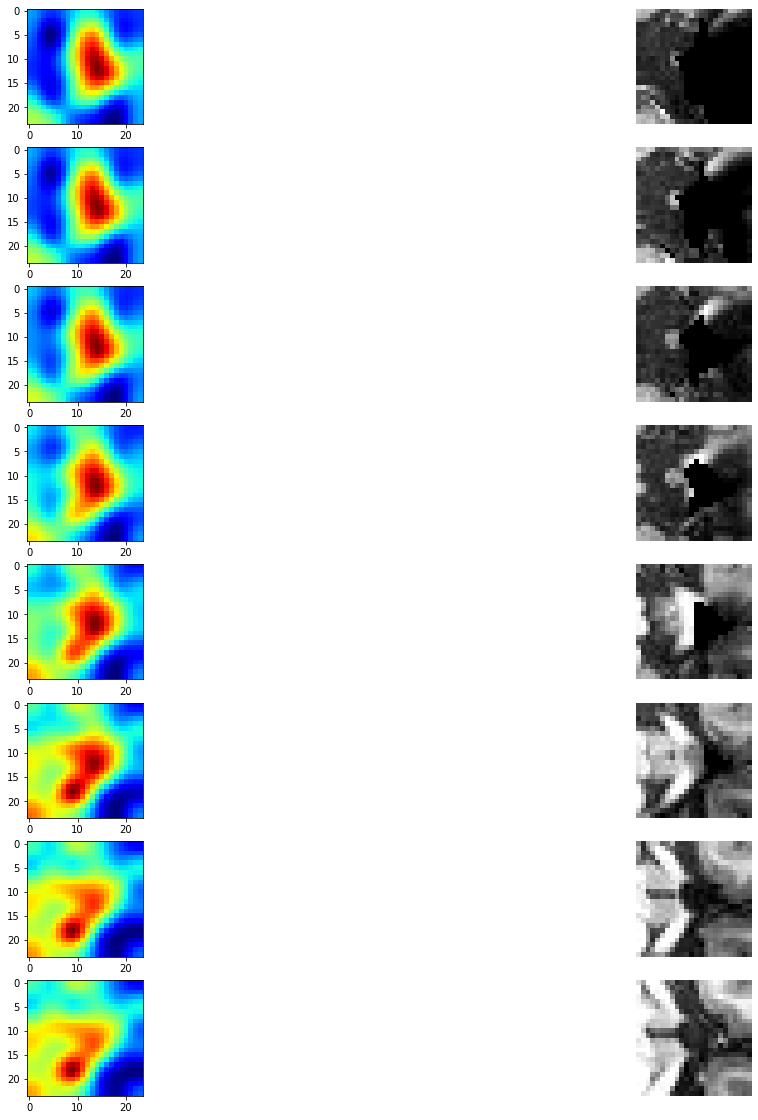

In [299]:
fig = plt.figure(figsize=(20,20))

for i in range(example.shape[4]):
    
    plt.subplot(example.shape[4],2,2*i+1)
    plt.imshow(example_resampled[:,:,i], cmap='jet', alpha = 1)
    plt.subplot(example.shape[4],2,2*i+2)
    plt.imshow(example[0,0,:,:,i], cmap='gray', alpha = 1);
    #plt.title(str(labels.numpy()[i])+' vs prediction= '+str(output[i][0]))    
    plt.axis('off')

plt.show()

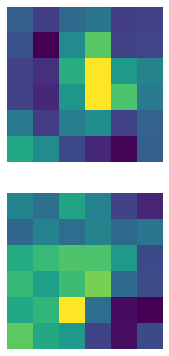

In [301]:
fig = plt.figure(figsize=(20,20))

for i in range(explanation.shape[2]):

    plt.subplot(explanation.shape[0],1,i+1)
    plt.imshow(explanation[:,:,i]);
    #plt.title(str(labels.numpy()[i])+' vs prediction= '+str(output[i][0]))    
    plt.axis('off')

plt.show()

In [150]:
prediction

tensor([[0.4681]], grad_fn=<SigmoidBackward>)

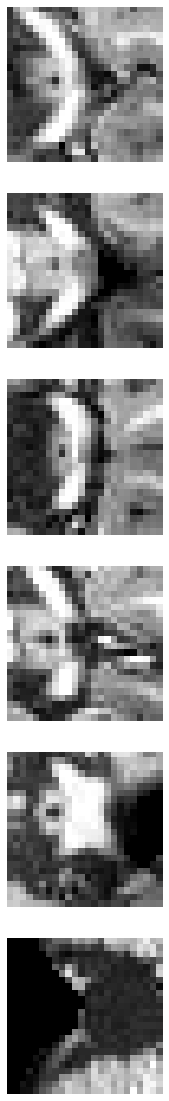

In [70]:
fig = plt.figure(figsize=(20,20))

for i in range(prediction.shape[0]):

    plt.subplot(inputs.shape[0],1,i+1)
    plt.imshow(inputs[i,0,:,:,5],cmap='gray');
    #plt.title(str(labels.numpy()[i])+' vs prediction= '+str(output[i][0]))    
    plt.axis('off')

plt.show()

In [27]:
# Count layers where require_grad = True
counter = 0
for layer in classifying_network.children():
    for param in layer.parameters():
        if param.requires_grad == True:
            counter += 1

print(counter)
            

20


In [28]:
# Freeze the network
classifying_network.freeze_feature_extraction()

In [29]:
# Count layers where require_grad = True
counter = 0
for layer in classifying_network.children():
    for param in layer.parameters():
        if param.requires_grad == True:
            counter += 1

print(counter)
            

2


In [18]:
#print(classifying_network)

In [22]:
input_example = torch.from_numpy(inputs)
input_example.requires_grad = True

data = classifying_network(input_example)
print(data.shape)
print(data)

torch.Size([6, 1152])
torch.Size([6, 1])
tensor([[0.3878],
        [0.4795],
        [0.3825],
        [0.4782],
        [0.4904],
        [0.4491]], grad_fn=<SigmoidBackward>)


In [31]:
print(classifying_network.output_latent_representations(input_example).shape)

torch.Size([6, 16, 6, 6, 2])


In [32]:
print(classifying_network.output_activation_gradient())

None


In [33]:
#data[1,:].backward()

In [34]:
#print(classifying_network.output_activation_gradient())

In [35]:
# Moar
#classifying_network.gradients

## Training

In [36]:
# Try setting CUDA if possible
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu") 
    
print(device)

cuda


In [37]:
# Criterion
criterion = nn.BCELoss()

# Optimizer
#optimizer = torch.optim.Adam(params=classifying_network.parameters(), lr=0.0001)
optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, classifying_network.parameters()), lr=0.0001)

# Number of epochs
n_epochs = 100

In [38]:
# Exemplary use of criterion

In [39]:
batch[1]['albinism']

tensor([0, 1, 1, 0, 0, 1])

In [40]:
data

tensor([[0.4973],
        [0.4968],
        [0.4075],
        [0.5625],
        [0.6042],
        [0.5764]], grad_fn=<SigmoidBackward>)

In [41]:
criterion(data.reshape(-1), batch[1]['albinism'].float())

tensor(0.7649, grad_fn=<BinaryCrossEntropyBackward>)

In [42]:
# Prediction
(data>0.5).reshape(-1)

tensor([False, False, False,  True,  True,  True])

In [43]:
# Labels
batch[1]['albinism']

tensor([0, 1, 1, 0, 0, 1])

In [44]:
# Calculate accuracy
print(accuracy_score((data>0.5).reshape(-1),batch[1]['albinism']))

0.3333333333333333


In [45]:
# Function returning trained model
def train_network(n_epochs, dataloaders, model, optimizer, criterion, device, save_path):
    
    track_train_loss = []
    track_train_dev_loss = []
    track_test_dev_loss = []
    
    track_train_acc = []
    track_train_dev_acc = []
    track_test_dev_acc = []
    
    valid_loss_min = np.Inf
    
    model.to(device)
        
    for epoch in tqdm(range(1, n_epochs+1)):
        
        # Initialize loss monitoring variables
        train_loss = 0.0
        train_dev_loss = 0.0
        test_dev_loss = 0.0
        
        train_acc = 0.0
        train_dev_acc = 0.0
        test_dev_acc = 0.0
        
        i = 0
        j = 0
        k = 0
                
        # Training
        model.train()
        
        for batch in dataloaders['train']:
            
            data = batch['t1']['data'].to(device)
            data.requires_grad = True
            
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output.reshape(-1), batch['albinism'].float().to(device))
            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy_score((output>0.5).reshape(-1).cpu(),batch['albinism'])
            
            i+=1
            
        track_train_loss.append(train_loss/i)
        track_train_acc.append(train_acc/i)
        
        # Validation on two datasets
        model.eval()
        
        for batch in dataloaders['train_dev']:
            
            data = batch['t1']['data'].to(device)
            data.requires_grad = True
            
            with torch.no_grad():
                
                output = model(data)
                loss = criterion(output.reshape(-1), batch['albinism'].float().to(device))
                
                train_dev_loss += loss.item()
                train_dev_acc += accuracy_score((output>0.5).reshape(-1).cpu(),batch['albinism'])
                
                j+=1
                
        track_train_dev_loss.append(train_dev_loss/j)
        track_train_dev_acc.append(train_dev_acc/j)
        
        
        for batch in dataloaders['test_dev']:
            
            data = batch['t1']['data'].to(device)
            data.requires_grad = True
            
            with torch.no_grad():
                
                output = model(data)
                loss = criterion(output.reshape(-1), batch['albinism'].float().to(device))
                
                test_dev_loss += loss.item()
                test_dev_acc += accuracy_score((output>0.5).reshape(-1).cpu(),batch['albinism'])
                
                k+=1
                
        track_test_dev_loss.append(test_dev_loss/k)
        track_test_dev_acc.append(test_dev_acc/k)
        
        print('END OF EPOCH: {} \nTraining acc per batch: {:.6f}\nTraining_dev acc per batch: {:.6f}\nTest_dev acc per batch: {:.6f}'.format(epoch, train_acc/i, train_dev_acc/j, test_dev_acc/k))
       
        
        ## Save the model if reached min validation loss
        if train_dev_loss + test_dev_loss < valid_loss_min:
            valid_loss_min = train_dev_loss + test_dev_loss
            torch.save(model.state_dict(),save_path)
                        
    # return trained model
    return model, track_train_loss, track_train_dev_loss, track_test_dev_loss, track_train_acc, track_train_dev_acc, track_test_dev_acc       

In [46]:
trained_model, train_loss, train_dev_loss, test_dev_loss, track_train_acc, track_train_dev_acc, track_test_dev_acc = train_network(100, dataloader_chiasms, classifying_network, optimizer, criterion, device,'first_model.pt')

  1%|          | 1/100 [00:09<15:04,  9.14s/it]

END OF EPOCH: 1 
Training acc per batch: 0.557143
Training_dev acc per batch: 0.416667
Test_dev acc per batch: 0.333333


  2%|▏         | 2/100 [00:09<10:40,  6.54s/it]

END OF EPOCH: 2 
Training acc per batch: 0.642857
Training_dev acc per batch: 0.572222
Test_dev acc per batch: 0.166667


  3%|▎         | 3/100 [00:10<07:38,  4.73s/it]

END OF EPOCH: 3 
Training acc per batch: 0.600000
Training_dev acc per batch: 0.572222
Test_dev acc per batch: 0.166667


  4%|▍         | 4/100 [00:10<05:30,  3.45s/it]

END OF EPOCH: 4 
Training acc per batch: 0.714286
Training_dev acc per batch: 0.577778
Test_dev acc per batch: 0.333333


  5%|▌         | 5/100 [00:11<04:01,  2.55s/it]

END OF EPOCH: 5 
Training acc per batch: 0.785714
Training_dev acc per batch: 0.627778
Test_dev acc per batch: 0.333333


  6%|▌         | 6/100 [00:11<03:00,  1.92s/it]

END OF EPOCH: 6 
Training acc per batch: 0.757143
Training_dev acc per batch: 0.633333
Test_dev acc per batch: 0.333333


  7%|▋         | 7/100 [00:11<02:17,  1.48s/it]

END OF EPOCH: 7 
Training acc per batch: 0.700000
Training_dev acc per batch: 0.633333
Test_dev acc per batch: 0.333333


  8%|▊         | 8/100 [00:12<01:48,  1.18s/it]

END OF EPOCH: 8 
Training acc per batch: 0.785714
Training_dev acc per batch: 0.627778
Test_dev acc per batch: 0.500000


  9%|▉         | 9/100 [00:12<01:27,  1.04it/s]

END OF EPOCH: 9 
Training acc per batch: 0.828571
Training_dev acc per batch: 0.627778
Test_dev acc per batch: 0.500000


 10%|█         | 10/100 [00:13<01:12,  1.24it/s]

END OF EPOCH: 10 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.677778
Test_dev acc per batch: 0.500000


 11%|█         | 11/100 [00:13<01:02,  1.41it/s]

END OF EPOCH: 11 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.677778
Test_dev acc per batch: 0.500000


 12%|█▏        | 12/100 [00:14<00:56,  1.57it/s]

END OF EPOCH: 12 
Training acc per batch: 0.828571
Training_dev acc per batch: 0.683333
Test_dev acc per batch: 0.500000


 13%|█▎        | 13/100 [00:14<00:50,  1.72it/s]

END OF EPOCH: 13 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.688889
Test_dev acc per batch: 0.500000


 14%|█▍        | 14/100 [00:15<00:46,  1.85it/s]

END OF EPOCH: 14 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.677778
Test_dev acc per batch: 0.500000


 15%|█▌        | 15/100 [00:15<00:43,  1.93it/s]

END OF EPOCH: 15 
Training acc per batch: 0.857143
Training_dev acc per batch: 0.688889
Test_dev acc per batch: 0.500000


 16%|█▌        | 16/100 [00:16<00:42,  2.00it/s]

END OF EPOCH: 16 
Training acc per batch: 0.785714
Training_dev acc per batch: 0.683333
Test_dev acc per batch: 0.500000


 17%|█▋        | 17/100 [00:16<00:40,  2.05it/s]

END OF EPOCH: 17 
Training acc per batch: 0.785714
Training_dev acc per batch: 0.688889
Test_dev acc per batch: 0.500000


 18%|█▊        | 18/100 [00:16<00:38,  2.12it/s]

END OF EPOCH: 18 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.683333
Test_dev acc per batch: 0.500000


 19%|█▉        | 19/100 [00:17<00:37,  2.15it/s]

END OF EPOCH: 19 
Training acc per batch: 0.842857
Training_dev acc per batch: 0.727778
Test_dev acc per batch: 0.500000


 20%|██        | 20/100 [00:17<00:36,  2.19it/s]

END OF EPOCH: 20 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 21%|██        | 21/100 [00:18<00:35,  2.22it/s]

END OF EPOCH: 21 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 22%|██▏       | 22/100 [00:18<00:36,  2.14it/s]

END OF EPOCH: 22 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 23%|██▎       | 23/100 [00:19<00:37,  2.05it/s]

END OF EPOCH: 23 
Training acc per batch: 0.800000
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 24%|██▍       | 24/100 [00:19<00:37,  2.03it/s]

END OF EPOCH: 24 
Training acc per batch: 0.828571
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 25%|██▌       | 25/100 [00:20<00:36,  2.05it/s]

END OF EPOCH: 25 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 26%|██▌       | 26/100 [00:20<00:35,  2.10it/s]

END OF EPOCH: 26 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 27%|██▋       | 27/100 [00:21<00:35,  2.08it/s]

END OF EPOCH: 27 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 28%|██▊       | 28/100 [00:21<00:35,  2.05it/s]

END OF EPOCH: 28 
Training acc per batch: 0.857143
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 29%|██▉       | 29/100 [00:22<00:34,  2.04it/s]

END OF EPOCH: 29 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 30%|███       | 30/100 [00:22<00:34,  2.04it/s]

END OF EPOCH: 30 
Training acc per batch: 0.800000
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 31%|███       | 31/100 [00:23<00:33,  2.04it/s]

END OF EPOCH: 31 
Training acc per batch: 0.857143
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 32%|███▏      | 32/100 [00:23<00:32,  2.11it/s]

END OF EPOCH: 32 
Training acc per batch: 0.828571
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 33%|███▎      | 33/100 [00:24<00:31,  2.15it/s]

END OF EPOCH: 33 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 34%|███▍      | 34/100 [00:24<00:30,  2.13it/s]

END OF EPOCH: 34 
Training acc per batch: 0.842857
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 35%|███▌      | 35/100 [00:25<00:30,  2.11it/s]

END OF EPOCH: 35 
Training acc per batch: 0.842857
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 36%|███▌      | 36/100 [00:25<00:29,  2.16it/s]

END OF EPOCH: 36 
Training acc per batch: 0.857143
Training_dev acc per batch: 0.727778
Test_dev acc per batch: 0.500000


 37%|███▋      | 37/100 [00:25<00:29,  2.16it/s]

END OF EPOCH: 37 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.727778
Test_dev acc per batch: 0.500000


 38%|███▊      | 38/100 [00:26<00:28,  2.17it/s]

END OF EPOCH: 38 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 39%|███▉      | 39/100 [00:26<00:27,  2.20it/s]

END OF EPOCH: 39 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 40%|████      | 40/100 [00:27<00:28,  2.14it/s]

END OF EPOCH: 40 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 41%|████      | 41/100 [00:27<00:28,  2.09it/s]

END OF EPOCH: 41 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 42%|████▏     | 42/100 [00:28<00:27,  2.07it/s]

END OF EPOCH: 42 
Training acc per batch: 0.842857
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 43%|████▎     | 43/100 [00:28<00:27,  2.04it/s]

END OF EPOCH: 43 
Training acc per batch: 0.857143
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 44%|████▍     | 44/100 [00:29<00:28,  1.97it/s]

END OF EPOCH: 44 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 45%|████▌     | 45/100 [00:29<00:26,  2.06it/s]

END OF EPOCH: 45 
Training acc per batch: 0.900000
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 46%|████▌     | 46/100 [00:30<00:26,  2.05it/s]

END OF EPOCH: 46 
Training acc per batch: 0.828571
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 47%|████▋     | 47/100 [00:30<00:25,  2.06it/s]

END OF EPOCH: 47 
Training acc per batch: 0.828571
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 48%|████▊     | 48/100 [00:31<00:24,  2.14it/s]

END OF EPOCH: 48 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 49%|████▉     | 49/100 [00:31<00:24,  2.10it/s]

END OF EPOCH: 49 
Training acc per batch: 0.842857
Training_dev acc per batch: 0.727778
Test_dev acc per batch: 0.500000


 50%|█████     | 50/100 [00:32<00:23,  2.10it/s]

END OF EPOCH: 50 
Training acc per batch: 0.857143
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 51%|█████     | 51/100 [00:32<00:22,  2.13it/s]

END OF EPOCH: 51 
Training acc per batch: 0.857143
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 52%|█████▏    | 52/100 [00:33<00:22,  2.18it/s]

END OF EPOCH: 52 
Training acc per batch: 0.857143
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 53%|█████▎    | 53/100 [00:33<00:22,  2.11it/s]

END OF EPOCH: 53 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.750000
Test_dev acc per batch: 0.500000


 54%|█████▍    | 54/100 [00:34<00:21,  2.11it/s]

END OF EPOCH: 54 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 55%|█████▌    | 55/100 [00:34<00:21,  2.10it/s]

END OF EPOCH: 55 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 56%|█████▌    | 56/100 [00:35<00:21,  2.06it/s]

END OF EPOCH: 56 
Training acc per batch: 0.857143
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 57%|█████▋    | 57/100 [00:35<00:20,  2.07it/s]

END OF EPOCH: 57 
Training acc per batch: 0.842857
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 58%|█████▊    | 58/100 [00:36<00:20,  2.03it/s]

END OF EPOCH: 58 
Training acc per batch: 0.857143
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 59%|█████▉    | 59/100 [00:36<00:19,  2.06it/s]

END OF EPOCH: 59 
Training acc per batch: 0.800000
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 60%|██████    | 60/100 [00:37<00:19,  2.08it/s]

END OF EPOCH: 60 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 61%|██████    | 61/100 [00:37<00:18,  2.06it/s]

END OF EPOCH: 61 
Training acc per batch: 0.857143
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 62%|██████▏   | 62/100 [00:38<00:18,  2.04it/s]

END OF EPOCH: 62 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.727778
Test_dev acc per batch: 0.500000


 63%|██████▎   | 63/100 [00:38<00:18,  2.05it/s]

END OF EPOCH: 63 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 64%|██████▍   | 64/100 [00:38<00:16,  2.13it/s]

END OF EPOCH: 64 
Training acc per batch: 0.814286
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 65%|██████▌   | 65/100 [00:39<00:16,  2.19it/s]

END OF EPOCH: 65 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 66%|██████▌   | 66/100 [00:39<00:15,  2.22it/s]

END OF EPOCH: 66 
Training acc per batch: 0.842857
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 67%|██████▋   | 67/100 [00:40<00:15,  2.20it/s]

END OF EPOCH: 67 
Training acc per batch: 0.885714
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 68%|██████▊   | 68/100 [00:40<00:14,  2.20it/s]

END OF EPOCH: 68 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.727778
Test_dev acc per batch: 0.500000


 69%|██████▉   | 69/100 [00:41<00:14,  2.16it/s]

END OF EPOCH: 69 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 70%|███████   | 70/100 [00:41<00:13,  2.22it/s]

END OF EPOCH: 70 
Training acc per batch: 0.857143
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 71%|███████   | 71/100 [00:42<00:12,  2.23it/s]

END OF EPOCH: 71 
Training acc per batch: 0.885714
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 72%|███████▏  | 72/100 [00:42<00:12,  2.16it/s]

END OF EPOCH: 72 
Training acc per batch: 0.900000
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 73%|███████▎  | 73/100 [00:43<00:12,  2.14it/s]

END OF EPOCH: 73 
Training acc per batch: 0.900000
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 74%|███████▍  | 74/100 [00:43<00:11,  2.18it/s]

END OF EPOCH: 74 
Training acc per batch: 0.842857
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 75%|███████▌  | 75/100 [00:43<00:11,  2.10it/s]

END OF EPOCH: 75 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 76%|███████▌  | 76/100 [00:44<00:11,  2.13it/s]

END OF EPOCH: 76 
Training acc per batch: 0.828571
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 77%|███████▋  | 77/100 [00:44<00:10,  2.10it/s]

END OF EPOCH: 77 
Training acc per batch: 0.885714
Training_dev acc per batch: 0.727778
Test_dev acc per batch: 0.500000


 78%|███████▊  | 78/100 [00:45<00:10,  2.14it/s]

END OF EPOCH: 78 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.727778
Test_dev acc per batch: 0.500000


 79%|███████▉  | 79/100 [00:45<00:09,  2.18it/s]

END OF EPOCH: 79 
Training acc per batch: 0.885714
Training_dev acc per batch: 0.727778
Test_dev acc per batch: 0.500000


 80%|████████  | 80/100 [00:46<00:09,  2.16it/s]

END OF EPOCH: 80 
Training acc per batch: 0.900000
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 81%|████████  | 81/100 [00:46<00:08,  2.16it/s]

END OF EPOCH: 81 
Training acc per batch: 0.885714
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 82%|████████▏ | 82/100 [00:47<00:08,  2.19it/s]

END OF EPOCH: 82 
Training acc per batch: 0.857143
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 83%|████████▎ | 83/100 [00:47<00:07,  2.15it/s]

END OF EPOCH: 83 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 84%|████████▍ | 84/100 [00:48<00:07,  2.17it/s]

END OF EPOCH: 84 
Training acc per batch: 0.885714
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 85%|████████▌ | 85/100 [00:48<00:06,  2.21it/s]

END OF EPOCH: 85 
Training acc per batch: 0.914286
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 86%|████████▌ | 86/100 [00:49<00:06,  2.13it/s]

END OF EPOCH: 86 
Training acc per batch: 0.914286
Training_dev acc per batch: 0.727778
Test_dev acc per batch: 0.500000


 87%|████████▋ | 87/100 [00:49<00:06,  2.07it/s]

END OF EPOCH: 87 
Training acc per batch: 0.885714
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 88%|████████▊ | 88/100 [00:50<00:05,  2.10it/s]

END OF EPOCH: 88 
Training acc per batch: 0.914286
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 89%|████████▉ | 89/100 [00:50<00:05,  2.17it/s]

END OF EPOCH: 89 
Training acc per batch: 0.871429
Training_dev acc per batch: 0.727778
Test_dev acc per batch: 0.500000


 90%|█████████ | 90/100 [00:50<00:04,  2.17it/s]

END OF EPOCH: 90 
Training acc per batch: 0.885714
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 91%|█████████ | 91/100 [00:51<00:04,  2.20it/s]

END OF EPOCH: 91 
Training acc per batch: 0.900000
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 92%|█████████▏| 92/100 [00:51<00:03,  2.23it/s]

END OF EPOCH: 92 
Training acc per batch: 0.914286
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


 93%|█████████▎| 93/100 [00:52<00:03,  2.24it/s]

END OF EPOCH: 93 
Training acc per batch: 0.900000
Training_dev acc per batch: 0.727778
Test_dev acc per batch: 0.500000


 94%|█████████▍| 94/100 [00:52<00:02,  2.20it/s]

END OF EPOCH: 94 
Training acc per batch: 0.900000
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 95%|█████████▌| 95/100 [00:53<00:02,  2.11it/s]

END OF EPOCH: 95 
Training acc per batch: 0.900000
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 96%|█████████▌| 96/100 [00:53<00:01,  2.09it/s]

END OF EPOCH: 96 
Training acc per batch: 0.885714
Training_dev acc per batch: 0.733333
Test_dev acc per batch: 0.500000


 97%|█████████▋| 97/100 [00:54<00:01,  1.98it/s]

END OF EPOCH: 97 
Training acc per batch: 0.857143
Training_dev acc per batch: 0.727778
Test_dev acc per batch: 0.500000


 98%|█████████▊| 98/100 [00:54<00:01,  1.95it/s]

END OF EPOCH: 98 
Training acc per batch: 0.885714
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


 99%|█████████▉| 99/100 [00:55<00:00,  1.99it/s]

END OF EPOCH: 99 
Training acc per batch: 0.900000
Training_dev acc per batch: 0.738889
Test_dev acc per batch: 0.500000


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]

END OF EPOCH: 100 
Training acc per batch: 0.942857
Training_dev acc per batch: 0.744444
Test_dev acc per batch: 0.500000


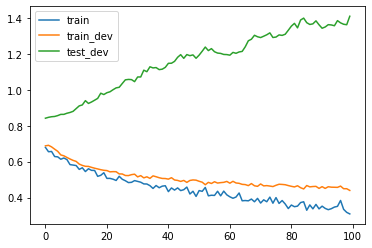

In [47]:
plt.plot(train_loss, label='train')
plt.plot(train_dev_loss, label='train_dev')
plt.plot(test_dev_loss, label='test_dev')
plt.legend();

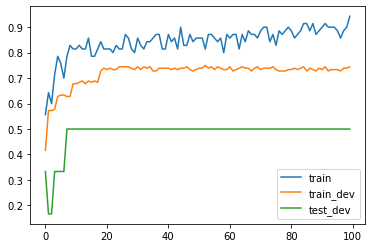

In [48]:
plt.plot(track_train_acc, label='train')
plt.plot(track_train_dev_acc, label='train_dev')
plt.plot(track_test_dev_acc, label='test_dev')
plt.legend();

# Evaluation

In [198]:
# Load trained model
classifying_network.load_state_dict(torch.load('first_model.pt'))

<All keys matched successfully>

train


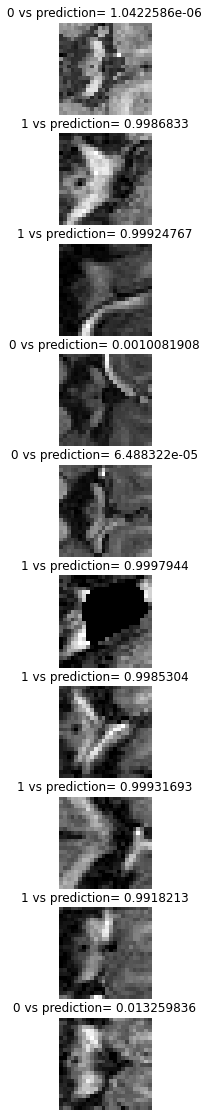

train_dev


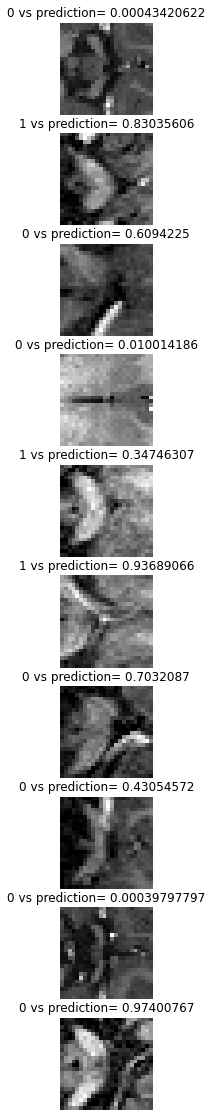

test_dev


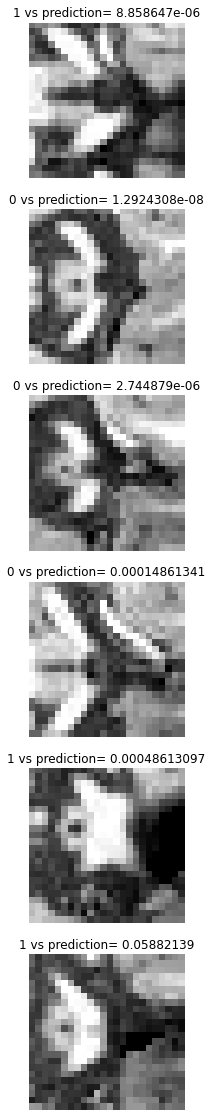

In [233]:
# Visualize results
for group in ['train', 'train_dev', 'test_dev']:
    
    print(group)
    
    batch = next(enumerate(dataloader_chiasms[group]))
    
    data = batch[1]['t1']['data']
    labels = batch[1]['albinism']
    
    inputs = data.cpu().numpy()
    
    output = classifying_network(data.to(device))
    output = (output.detach().cpu().numpy())
    
    fig = plt.figure(figsize=(20,20))
    
    for i in range(inputs.shape[0]):
                
        plt.subplot(inputs.shape[0],1,i+1)
        plt.imshow(inputs[i,0,:,:,5],cmap='gray');
        plt.title(str(labels.numpy()[i])+' vs prediction= '+str(output[i][0]))    
        plt.axis('off')
    
    plt.show()

In [ ]:
# GradCAM attempt

In [ ]:
# TO DO

# 0. ADDITIONAL LAYERS IN FC SECTION
# 1. ACQUIRE MORE IMAGES
# 2. RESIZE ALL IMAGES DURING PREPROCESSING
# 3. IMPLEMENT GRADCAM
# 4. IMPLEMENT LIME
# 5. IMPLEMENT SHAP
# 6. USE MORE DATA AUGMENTATION
# 7. CONSIDER K-FOLD VALIDATION
# 8. PENALIZE MISCLASIFICATION OF ALBINISM


In [ ]:
# Evaluate the model on all datasets

unet.eval()

for group in ['train', 'train_dev', 'test_dev']:
    
    i=0
    track_loss = 0
    
    for batch in dataloader[group]: 
        
            data = batch['t1']['data'].to(device)
            
            with torch.no_grad():
                
                output = unet(data)
                loss = criterion(output,data)
                
                track_loss += loss.item()
                i+=1
                
    print(group, ': loss per batch = ', track_loss/i)

In [ ]:
# Visualize the output (train_dev and test_dev)

# Generate sample from two dev datasets
train_dev_input = next(enumerate(dataloader['train_dev']))
test_dev_input = next(enumerate(dataloader['test_dev']))

In [ ]:
# Run network on samples
train_dev_output = unet(train_dev_input[1]['t1']['data'].to(device))
test_dev_output = unet(test_dev_input[1]['t1']['data'].to(device))

In [ ]:
# Visualize train_dev sample

inputs = train_dev_input[1]['t1']['data'].to('cpu')
outputs = train_dev_output.cpu().detach().numpy()

fig = plt.figure(figsize=(20,75))

print(outputs.shape[0])

for i in range(outputs.shape[0]):
    
    plt.subplot(outputs.shape[0],2,2*i+1)
    plt.imshow(inputs[i,0,:,:,5],cmap='gray');
    
    plt.subplot(outputs.shape[0],2,2*i+2)
    plt.imshow(outputs[i,0,:,:,5], cmap ='gray')
    
plt.show()

In [ ]:
# Visualize test-dev sample

inputs = test_dev_input[1]['t1']['data'].to('cpu')
outputs = test_dev_output.cpu().detach().numpy()

fig = plt.figure(figsize=(20,75))

print(outputs.shape[0])

for i in range(outputs.shape[0]):
    
    plt.subplot(outputs.shape[0],2,2*i+1)
    plt.imshow(inputs[i,0,:,:,5],cmap='gray');
    
    plt.subplot(outputs.shape[0],2,2*i+2)
    plt.imshow(outputs[i,0,:,:,5], cmap ='gray')
    
plt.show()

In [ ]:
# Visualize latent representations


In [ ]:
# TO DOs

# visualize latent representations

# visualize results on optic chiasm images only

# find out what's inside loaded files with standardization results